In [2]:
!pip install git+https://github.com/fujiisoup/pyspectra.git

import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra

data_path = join('/', 'Volumes', 'BUFFALO', 'SpectrometerData', '20201208_niihama')
print(os.path.exists(data_path))

  Cloning https://github.com/fujiisoup/pyspectra.git to /private/var/folders/ds/x3jwf2s54c3190fl2p4lrn3w0000gn/T/pip-req-build-5jszsr87
  Created wheel for pyspectra: filename=pyspectra-0.0.1-py3-none-any.whl size=18781 sha256=267c263f6c2e7ad4ac40b5fba4e79fccd4cdb8201fdaee5e1dbc3e13718cf679
  Stored in directory: /private/var/folders/ds/x3jwf2s54c3190fl2p4lrn3w0000gn/T/pip-ephem-wheel-cache-ef9ixsen/wheels/f2/02/84/9d89f8a4f86fa15ea48ce7f528a8a47f07613ef90ab688594c
Successfully built pyspectra
True


In [4]:
file_names = [f'H_{420000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [5]:
file_names = [f'back_{420000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

back_data = []
for i, p in enumerate(data['motor_coordinate']):
    d = data.sel(motor_coordinate=p).copy()
    d['long_x'] = d['x'][::-1] - 1000 * i
    d['x'] = data['x']
    back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')

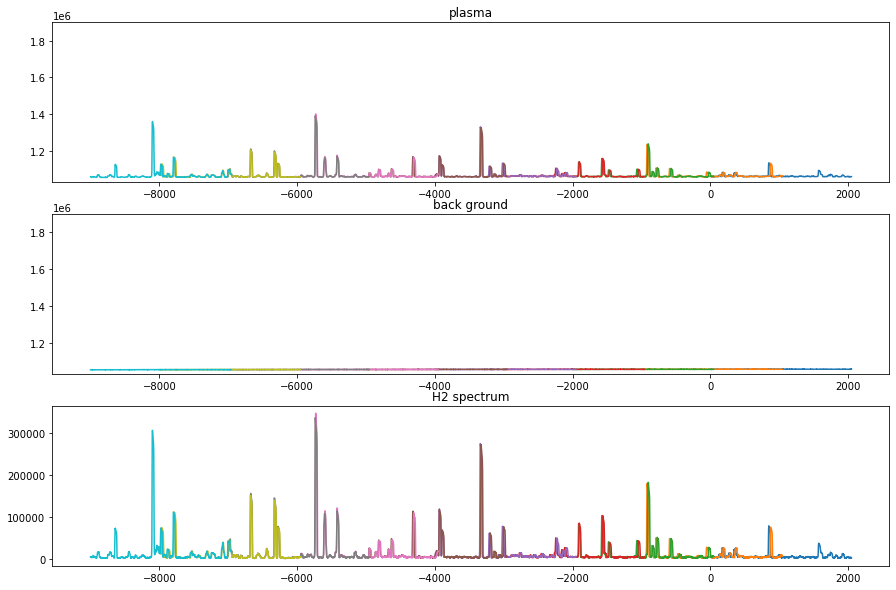

In [10]:
spectrum_data = plasma_data - back_data * 1.0

plt.figure(figsize=[15, 10])
plt.subplot(3, 1, 1)
plt.ylim(1.03*1e6, 1.9*1e6)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 2)
plt.title('back ground')
plt.ylim(1.03*1e6, 1.9*1e6)
for f in back_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 3)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

# 波長校正

In [11]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

(0.0, 30000.0)

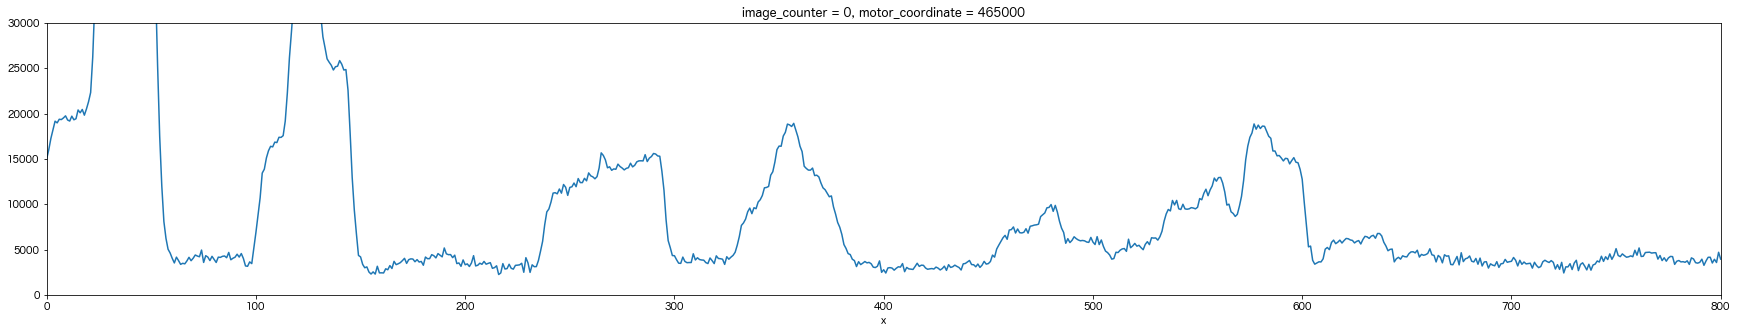

In [73]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()
plt.xlim(0, 800)
plt.ylim(0, 30000)

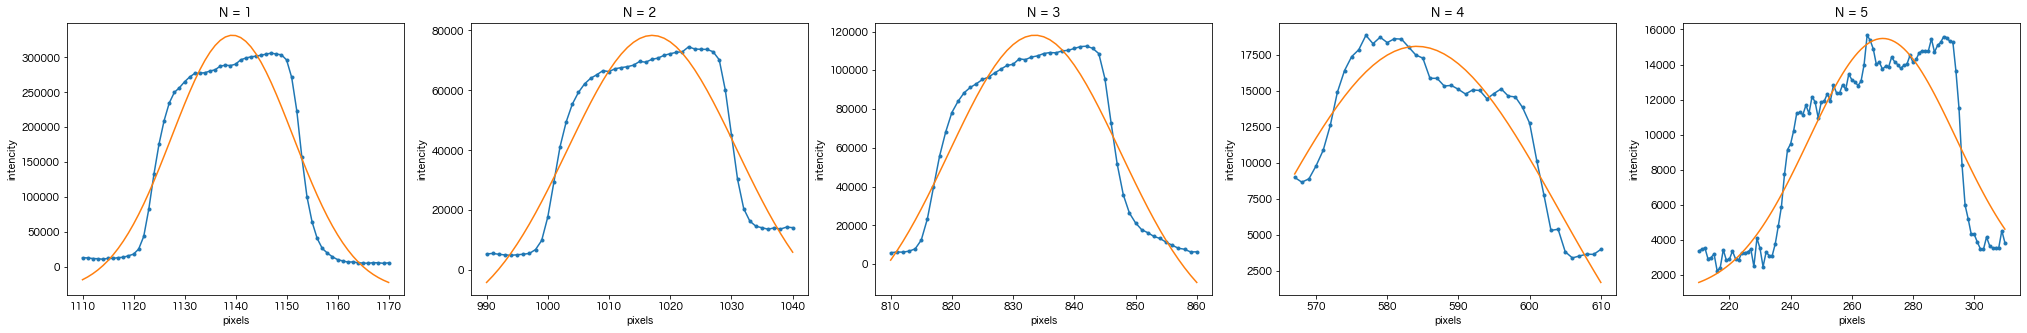

In [82]:
spectrum_lims = [
  [1110, 1170],
  [990, 1040],
  [810, 860],
  [567, 610],
  [210, 310],
#  [240, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 5))
Q1_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(spectrum_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 0
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  plt.subplot(1, len(spectrum_lims), i+1)
  result['data'].plot(marker='.')
  result['fit'].plot()
  plt.title('N = {}'.format(i+1))
  plt.xlabel('pixels')
  plt.ylabel('intencity')
  Q1_result.append(result)
Q1_result = xr.concat(Q1_result, dim='N')

Text(0, 0.5, 'area')

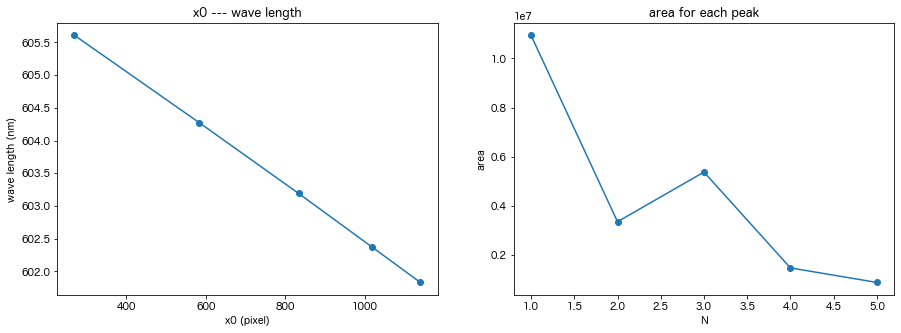

In [83]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q1_result['x0'], Q1_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q1_result['N'], Q1_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

# 感度校正
分光器のカウントは、露光時間と放射輝度に比例する

Text(0, 0.5, '放射輝度 ($W m^{-2} nm^{-1} sr^{-1}$)')

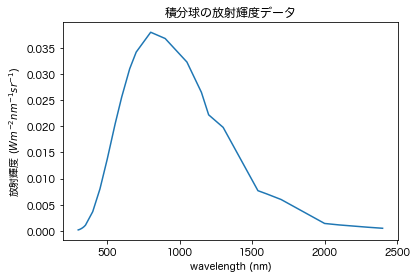

In [58]:
plt.title("積分球の放射輝度データ")
x_value = np.array([300,310,320,330,340,350,400,450,500,555,600,655,700,800,900,1050,1150,1200,1300,1540,1600,1700,2000,2100,2300,2400])
y_value = np.array([1.85e-2,2.80e-2,4.17e-2,5.89e-2,8.08e-2,1.09e-1,3.67e-1,8.03e-1,1.37e-0,2.05e-0,2.56e-0,3.10e-0,3.42e-0,3.80e-0,3.68e-0,3.23e-0,2.65e-0,2.22e-0,1.98e-0,7.69e-1,7.08e-1,6.00e-1,1.42e-1,1.14e-1,6.95e-2,5.01e-2])
plt.plot(x_value, y_value*1e-2)
plt.xlabel("wavelength (nm)")
plt.ylabel(r"放射輝度 ($W m^{-2} nm^{-1} sr^{-1}$)")

# ボルツマンフィッティング

(1500.0, 0.0)

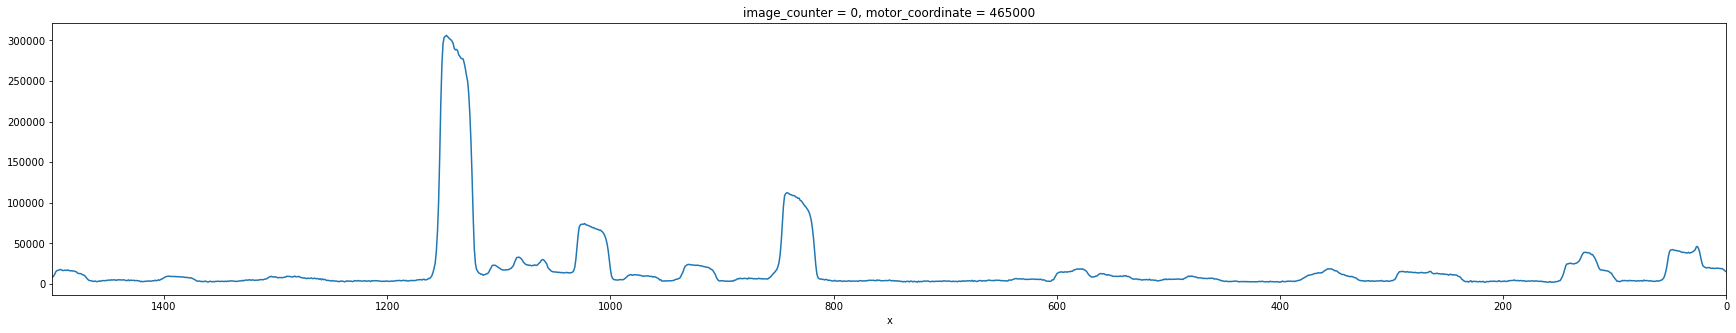

In [14]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()
plt.xlim(1500, 0)